In [1]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

%load_ext autoreload
%autoreload 2


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBRegressor

from src.features import build_features
from src.models import train_model

warnings.filterwarnings('ignore')
sns.set_style()
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
egresos_torax = pd.read_csv("../data/processed/egresos_torax_mes_y_dia.csv")
egresos_torax["FECHA_EGRESO"] = pd.to_datetime(
    egresos_torax["ANO_EGRESO"].astype(str)
    + "-"
    + egresos_torax["MES_EGRESO"].astype(str)
    + "-"
    + egresos_torax["DIA_EGRESO"].astype(str),
    format="%Y-%m-%d",
)

# dias_estada_grd = pd.read_excel("../data/processed/dias_estada_hospitalizados.xlsx")

canasta_hospitalizados_grd = pd.read_excel(
    "../data/processed/canasta_procedimientos_hospitalizados.xlsx"
)

Primero se quiere hacer un forecasting total de los egresos (sin desglose por diagnostico),
y tambien de los procedimientos necesarios totales


In [4]:
DIAGNOSTICO = "C341"

In [5]:
resumen_egresos_totales = (
    egresos_torax.query("DIAG1 == @DIAGNOSTICO and ANO_EGRESO == 2019")
    .groupby(["ANO_EGRESO"])["n_egresos"]
    .sum()
    .reset_index()
)
resumen_procedimientos_totales = canasta_hospitalizados_grd.query(
    "DIAGNOSTICO1 == 'C34.1' and ANIO_EGRESO == 2019"
)

In [6]:
EGRESOS_AUMENTADOS = 300
EGRESOS_2019 = resumen_egresos_totales.n_egresos.iloc[0]
AUMENTO_PROPORCIONAL = EGRESOS_AUMENTADOS / EGRESOS_2019

In [7]:
procedimientos_aumentados = resumen_procedimientos_totales.copy()
COLS_A_AUMENTAR = ["cantidad_procedimientos", "cantidad_pacientes_distintos"]

procedimientos_aumentados[COLS_A_AUMENTAR] = (
    procedimientos_aumentados[COLS_A_AUMENTAR] * AUMENTO_PROPORCIONAL
)

# 1. Forecasting

En este cuadernilllo se quiere predecir la cantidad de egresos hospitalarios que tendra
el Hospital del Torax a lo largo del tiempo. Ademas, se quire saber cuantos insumos se necesitaran
para atender tales casos.


In [8]:
resumen_egresos = egresos_torax.groupby(egresos_torax["FECHA_EGRESO"])["n_egresos"].sum().to_frame()

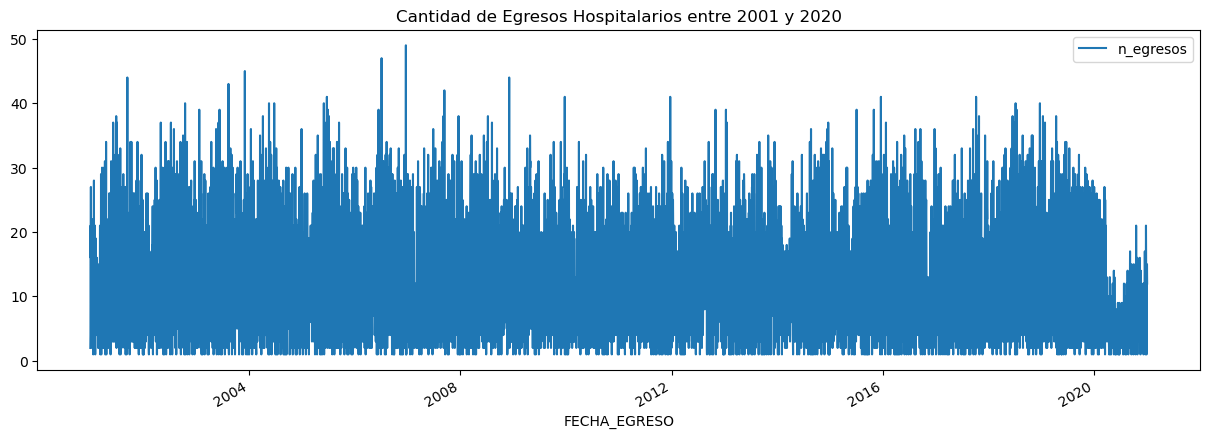

In [9]:
resumen_egresos.plot(figsize=(15, 5), title="Cantidad de Egresos Hospitalarios entre 2001 y 2020")
plt.show()

## Separacion en Train/Test


In [10]:
train = resumen_egresos[resumen_egresos.index < "01-01-2017"]
test = resumen_egresos[resumen_egresos.index >= "01-01-2017"]

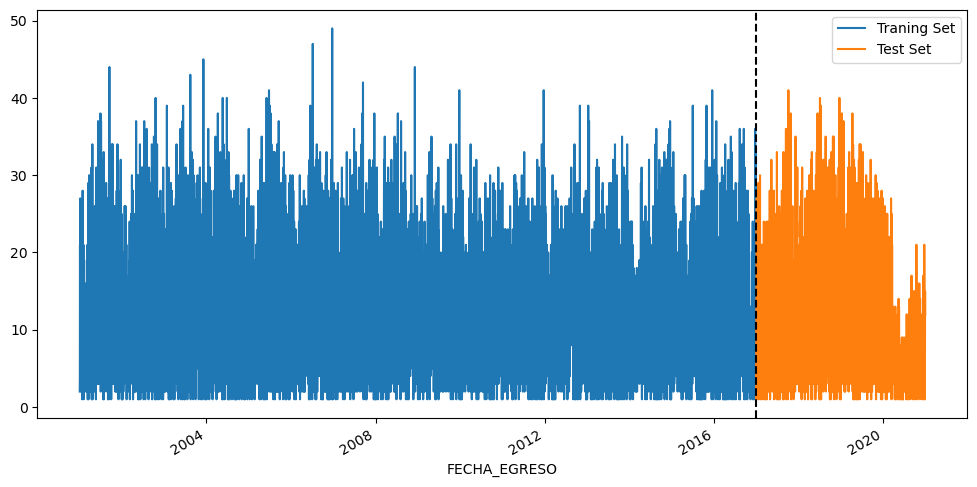

In [11]:
fig, axis = plt.subplots(1, 1, figsize=(12, 6))
train.plot(ax=axis, label="Traning")
test.plot(ax=axis, label="Test")
axis.axvline("01-01-2017", color="black", ls="--")
axis.legend(["Traning Set", "Test Set"])
plt.show()

In [12]:
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)

In [13]:
resumen_egresos

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays
FECHA_EGRESO,,,,,,,,,
2001-01-01,2,0,1,1,1,2001,1,0,1
2001-01-02,4,1,1,2,1,2001,2,0,0
2001-01-03,21,2,1,3,1,2001,3,0,0
2001-01-04,16,3,1,4,1,2001,4,0,0
2001-01-05,27,4,1,5,1,2001,5,0,0
...,...,...,...,...,...,...,...,...,...
2020-12-27,1,6,4,27,12,2020,362,1,0
2020-12-28,4,0,4,28,12,2020,363,0,0
2020-12-29,7,1,4,29,12,2020,364,0,0


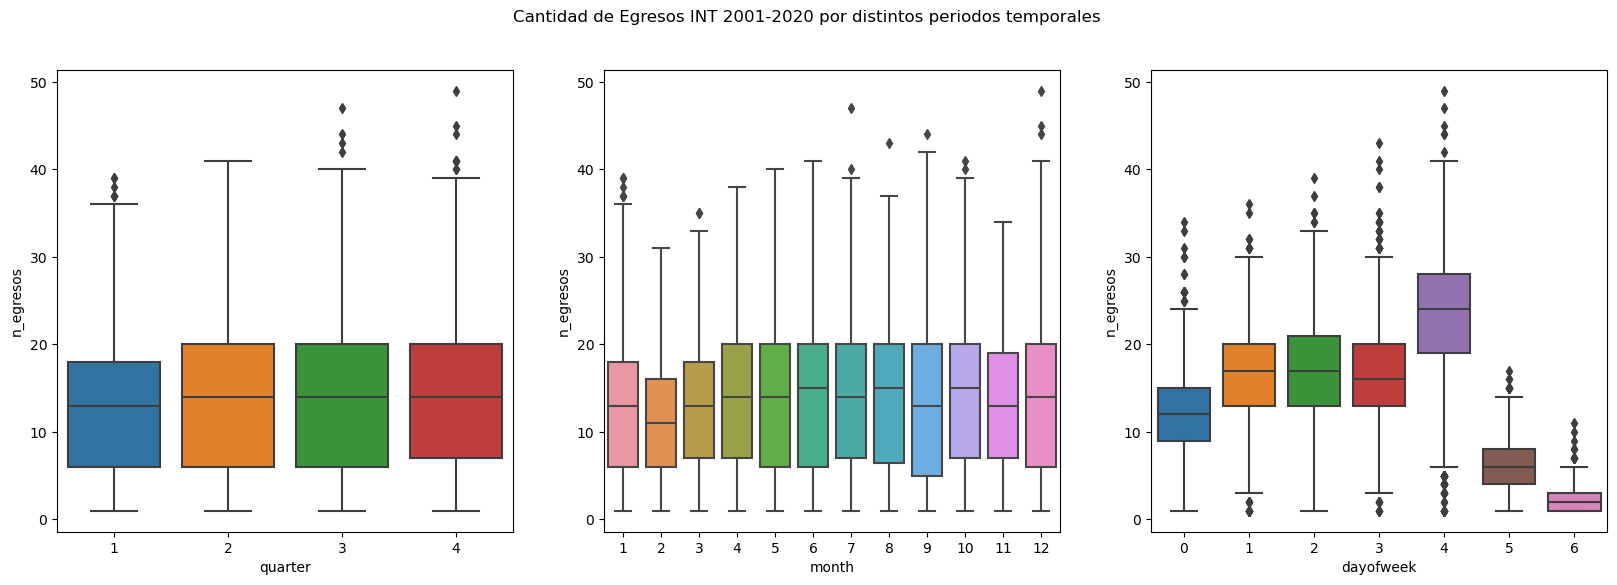

In [14]:
fig, axis = plt.subplots(1, 3, figsize=(20, 6))
sns.boxplot(data=resumen_egresos, x="quarter", y="n_egresos", ax=axis[0])
sns.boxplot(data=resumen_egresos, x="month", y="n_egresos", ax=axis[1])
sns.boxplot(data=resumen_egresos, x="dayofweek", y="n_egresos", ax=axis[2])
plt.suptitle("Cantidad de Egresos INT 2001-2020 por distintos periodos temporales")
plt.show()

Con estos resultados se puede observar que en el primer cuatrimestre existe una menor cantidad
de egresos hospitalarios. Ademas, se aprecia que la distribucion de egresos por mes es similar
a lo largo de cada mes. Sin embargo, es posible apreciar que en el mes de febrero existe una
baja en el promedio de egresos.

Dentro de una semana, se puede ver que la cantidad de egresos va aumentando durante la semana
laboral, teniendo un máximo los viernes. Además, se aprecia que los fin de semanas se tiene la
menor cantidad de egresos.


# 3. Creacion de Modelo


In [15]:
train = build_features.create_features_datetime_index(train)
test = build_features.create_features_datetime_index(test)

FEATURES = ["dayofweek", "quarter", "month", "year", "dayofyear", "weekend", "holidays"]
TARGET = "n_egresos"

In [16]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01)

In [18]:
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:15.65151	validation_1-rmse:15.08070


[100]	validation_0-rmse:7.14054	validation_1-rmse:7.66349
[200]	validation_0-rmse:4.90596	validation_1-rmse:5.92325
[300]	validation_0-rmse:4.41380	validation_1-rmse:5.65957
[400]	validation_0-rmse:4.25977	validation_1-rmse:5.62937
[466]	validation_0-rmse:4.19621	validation_1-rmse:5.64356


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Feature Importance


In [19]:
feature_importance = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["importance"]
)

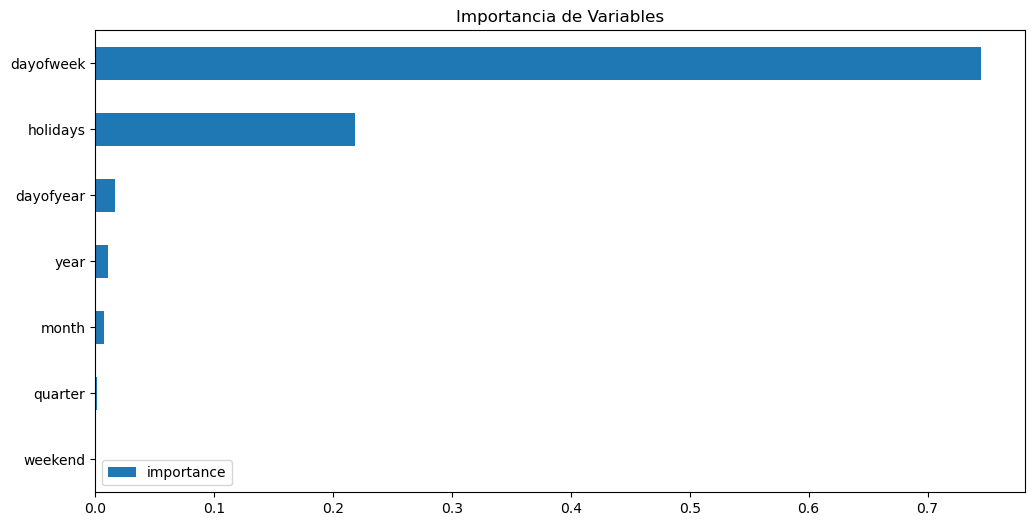

In [20]:
feature_importance.sort_values("importance").plot(kind="barh", title="Importancia de Variables")
plt.show()

Estos resultados indican que el dia de la semana es altamente importante para predecir los egresos
hospitalarios!. Además, la variable indicadora de feriados también es altamente relevante.


## Prediccion en Test


In [21]:
test["prediction"] = reg.predict(X_test)

In [22]:
resumen_egresos = resumen_egresos.merge(
    test["prediction"], how="left", left_index=True, right_index=True
)

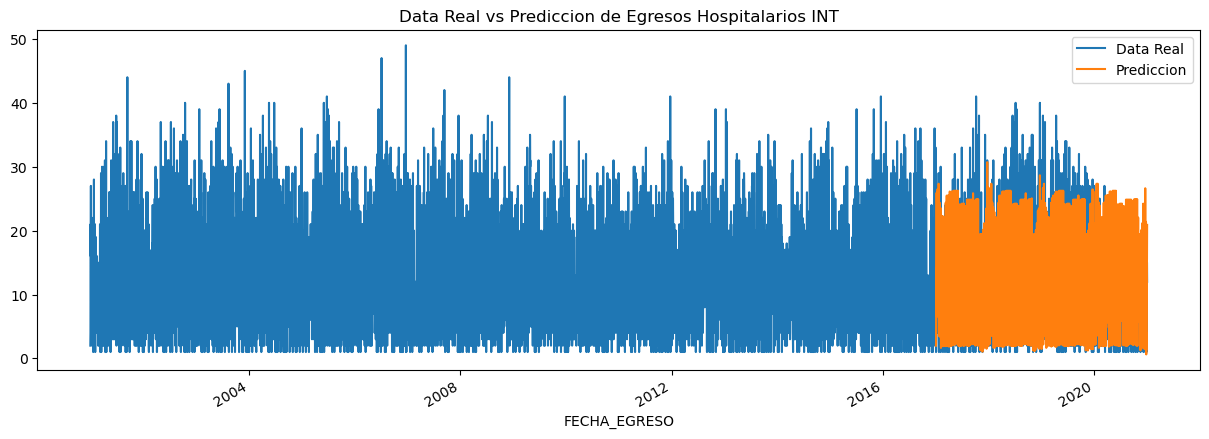

In [23]:
ax = resumen_egresos["n_egresos"].plot(figsize=(15, 5))
resumen_egresos["prediction"].plot(ax=ax)
plt.legend(["Data Real", "Prediccion"])
ax.set_title("Data Real vs Prediccion de Egresos Hospitalarios INT")
plt.show()

In [24]:
filtro_semana = resumen_egresos[
    (resumen_egresos.index >= "05-01-2017") & (resumen_egresos.index <= "07-01-2017")
]

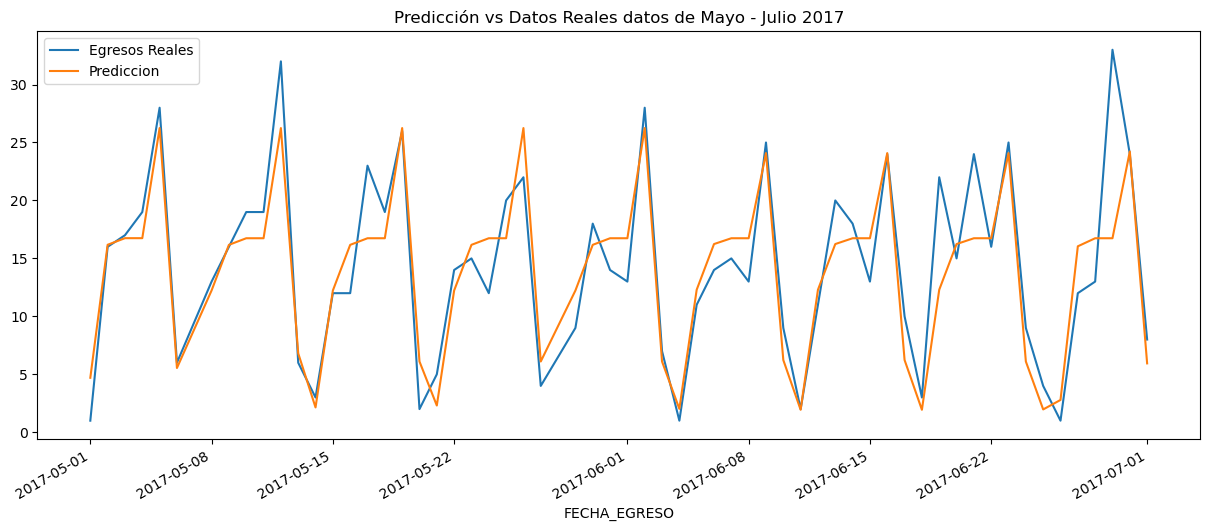

In [25]:
fig, axis = plt.subplots(figsize=(15, 6))
filtro_semana["n_egresos"].plot(ax=axis)
filtro_semana["prediction"].plot(ax=axis)
plt.legend(["Egresos Reales", "Prediccion"])
plt.title("Predicción vs Datos Reales datos de Mayo - Julio 2017")
plt.show()

Y aca se puede ver la cantidad de egresos en la primera semana de Mayo de 2017.


In [26]:
rmse_modelo = np.sqrt(mean_squared_error(test["n_egresos"], test["prediction"]))
print(f"El modelo tiene un RMSE de: {rmse_modelo:0f} egresos")

El modelo tiene un RMSE de: 5.628271 egresos


In [27]:
test["error"] = np.abs(test["n_egresos"] - test["prediction"])

In [28]:
test.sort_values("error", ascending=False).head(5)

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2017-10-26,38,3,4,26,10,2017,299,0,0,16.367750,21.632250
2020-06-19,3,4,2,19,6,2020,171,0,0,24.084307,21.084307
2020-06-05,3,4,2,5,6,2020,157,0,0,24.084307,21.084307
2020-05-22,6,4,2,22,5,2020,143,0,0,26.244677,20.244677
2020-10-02,5,4,4,2,10,2020,276,0,0,24.896091,19.896091


In [29]:
test.sort_values("error", ascending=False).tail(5)

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,error
FECHA_EGRESO,,,,,,,,,,,
2019-08-04,2,6,3,4,8,2019,216,1,0,2.016498,0.016498
2019-10-26,6,5,4,26,10,2019,299,1,0,6.016024,0.016024
2020-10-18,2,6,4,18,10,2020,292,1,0,2.010057,0.010057
2017-10-22,2,6,4,22,10,2017,295,1,0,2.010057,0.010057
2018-10-21,2,6,4,21,10,2018,294,1,0,2.010057,0.010057


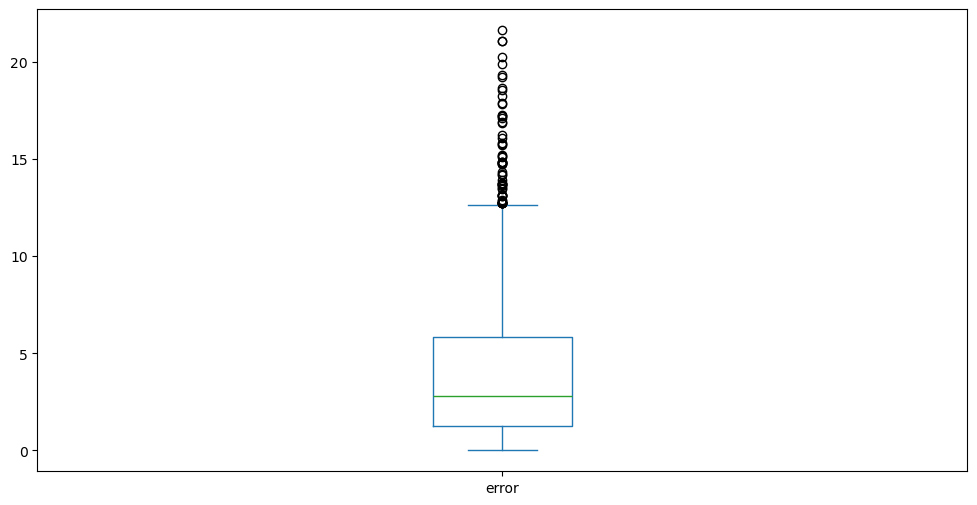

In [30]:
test["error"].plot(kind="box")
plt.show()

## Mejorando el modelo

Observamos que existen predicciones que tuvieron un error de hasta 26 egresos hospitalarios. Debido
a lo anterior, es necesario mejorar el modelo. Una de las formas mas efectivas de mejorar
el modelo es **remover outliers**!


## Remover Outliers

Se sabe que 2020 es un anio con grandes problemas (pandemia). Ademas, es posible observar una
disminucion significativa en la cantidad de egresos. Debido a esto, es necesario filtrar estos
anios.


In [31]:
resumen_egresos = resumen_egresos[resumen_egresos.index < "2020-01-01"]

Otra de las grandes mejores es hacer una validacion cruzada con las series de tiempo.


## Validacion Cruzada


In [32]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=1)
resumen_egresos = resumen_egresos.sort_index()

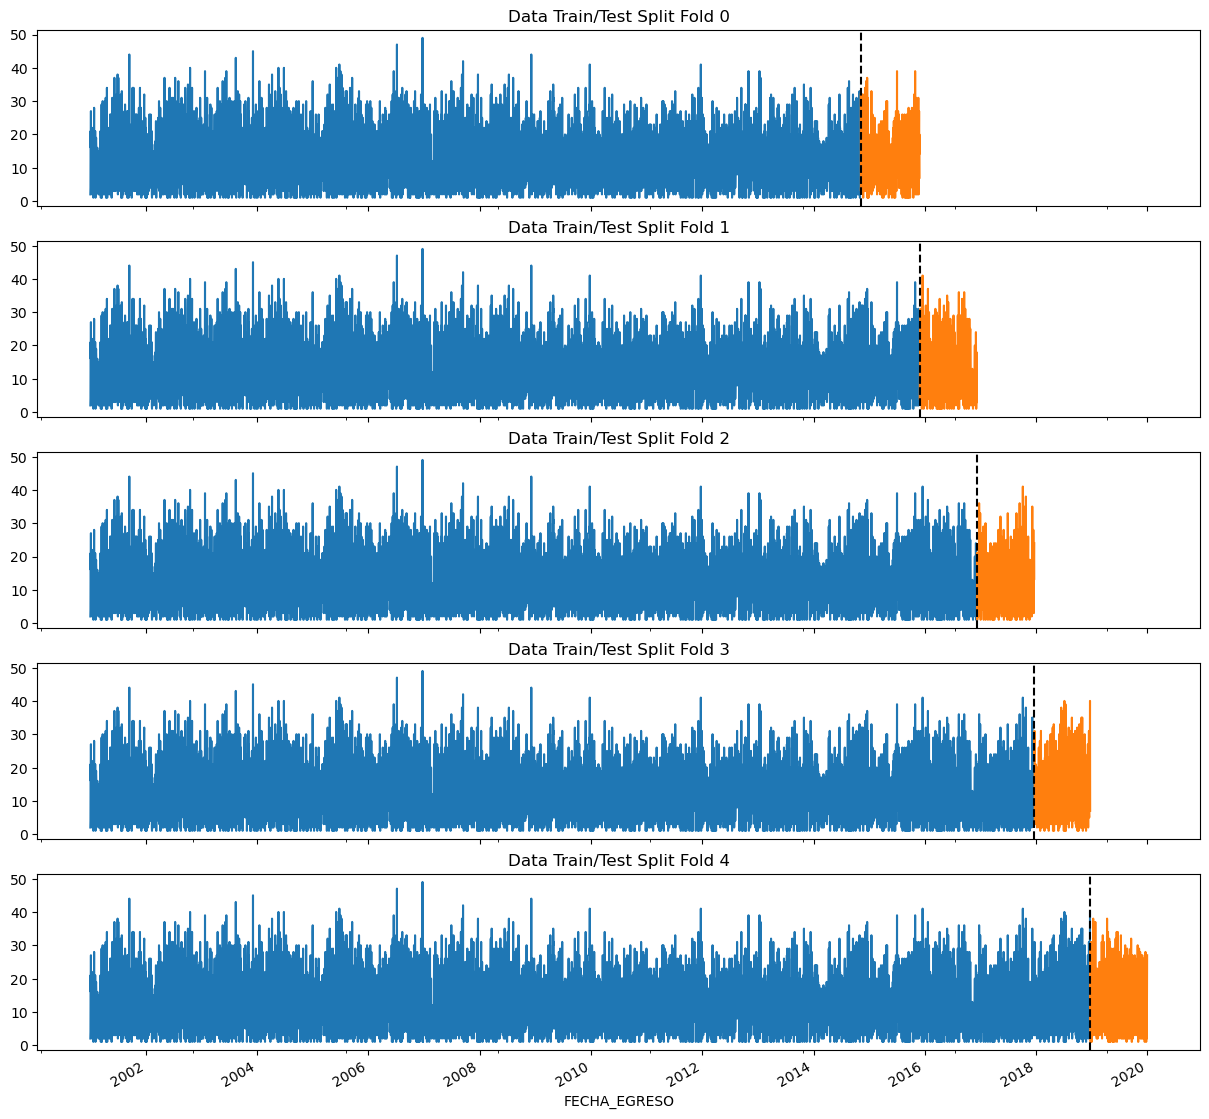

In [33]:
fig, axis = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[val_idx]

    train["n_egresos"].plot(
        ax=axis[fold], label="Training", title=f"Data Train/Test Split Fold {fold}"
    )
    test["n_egresos"].plot(ax=axis[fold], label="Test Set")
    axis[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

## Horizonte de Prediccion

Al final es asber cuantos anios se quiere predecir en el futuro. El nuevo hospital quiere
ser construido en 10 anios aproximadamente. Por lo tanto, el horizonte de prediccion es 10. Debido
a que es tan alejado, es normal que exista un mayor error.

Una forma de ver bien lo del horizonte es con las **lag features**.


## Lag Features

Son variables que indican el valores de egresos pero uno, dos, tres, etc... anios antes del
valor analizado.


In [34]:
resumen_egresos = build_features.add_lag_features(resumen_egresos, "n_egresos")

In [35]:
resumen_egresos.tail()

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,lag_1_anio,lag_2_anios,lag_3_anios
FECHA_EGRESO,,,,,,,,,,,,,
2019-12-27,24,4,4,27,12,2019,361,0,0,20.492285,31.0,21.0,33.0
2019-12-28,7,5,4,28,12,2019,362,1,0,5.520068,2.0,16.0,9.0
2019-12-29,2,6,4,29,12,2019,363,1,0,2.288286,11.0,3.0,4.0
2019-12-30,12,0,4,30,12,2019,364,0,0,13.855009,21.0,NaN,1.0
2019-12-31,27,1,4,31,12,2019,365,0,0,15.731440,1.0,7.0,4.0


## Entrenar con Validacion Cruzada


In [36]:
tss = TimeSeriesSplit(n_splits=5, test_size=365, gap=20)
resumen_egresos = resumen_egresos.sort_index()

In [37]:
fold = 0
predicciones = []
scores = []

for train_idx, valid_idx in tss.split(resumen_egresos):
    train = resumen_egresos.iloc[train_idx]
    test = resumen_egresos.iloc[valid_idx]

    train = build_features.create_features_datetime_index(train)
    test = build_features.create_features_datetime_index(test)

    FEATURES = [
        "dayofweek",
        "quarter",
        "month",
        "year",
        "dayofyear",
        "weekend",
        "holidays",
        "lag_1_anio",
        "lag_2_anios",
        "lag_3_anios",
    ]

    TARGET = "n_egresos"

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        objective="reg:squarederror",
        max_depth=3,
        learning_rate=0.01,
    )

    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

    y_pred = reg.predict(X_test)
    predicciones.append(y_pred)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(rmse)

[0]	validation_0-rmse:15.67409	validation_1-rmse:15.31052


[100]	validation_0-rmse:7.43623	validation_1-rmse:7.01006
[200]	validation_0-rmse:5.26814	validation_1-rmse:5.18759
[300]	validation_0-rmse:4.77939	validation_1-rmse:4.84132
[400]	validation_0-rmse:4.63416	validation_1-rmse:4.73776
[500]	validation_0-rmse:4.56012	validation_1-rmse:4.69652
[600]	validation_0-rmse:4.49810	validation_1-rmse:4.67096
[700]	validation_0-rmse:4.45786	validation_1-rmse:4.64286
[800]	validation_0-rmse:4.42591	validation_1-rmse:4.61468
[900]	validation_0-rmse:4.39233	validation_1-rmse:4.58743
[999]	validation_0-rmse:4.36890	validation_1-rmse:4.57134
[0]	validation_0-rmse:15.64454	validation_1-rmse:15.70648
[100]	validation_0-rmse:7.42426	validation_1-rmse:7.47190
[200]	validation_0-rmse:5.26902	validation_1-rmse:5.52495
[300]	validation_0-rmse:4.78966	validation_1-rmse:5.11624
[400]	validation_0-rmse:4.64811	validation_1-rmse:4.98929
[500]	validation_0-rmse:4.57716	validation_1-rmse:4.93483
[600]	validation_0-rmse:4.51871	validation_1-rmse:4.91316
[700]	validati

In [38]:
print(f"El RMSE promedio entre los 5 folds es: {np.mean(scores):.2f}")
print(f"Los scores de los folds fueron: {scores}")

El RMSE promedio entre los 5 folds es: 4.53
Los scores de los folds fueron: [4.5713376005363, 4.862091740120571, 4.235487629861959, 4.6514814657718455, 4.310141432730508]


Por lo tanto, el modelo tiene un error promedio de 4 egresos.

Una vez que ya vimos cuanto error tienen los modelos, es necesario entrenar un modelo con toda
la data para hacer predicciones en el futuro.


In [39]:
# Reentrena en toda la data, exceptuando con 2020
resumen_egresos = build_features.create_features_datetime_index(resumen_egresos)
display(resumen_egresos)

,n_egresos,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediction,lag_1_anio,lag_2_anios,lag_3_anios
FECHA_EGRESO,,,,,,,,,,,,,
2001-01-01,2,0,1,1,1,2001,1,0,1,NaN,NaN,NaN,NaN
2001-01-02,4,1,1,2,1,2001,2,0,0,NaN,NaN,NaN,NaN
2001-01-03,21,2,1,3,1,2001,3,0,0,NaN,NaN,NaN,NaN
2001-01-04,16,3,1,4,1,2001,4,0,0,NaN,NaN,NaN,NaN
2001-01-05,27,4,1,5,1,2001,5,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,24,4,4,27,12,2019,361,0,0,20.492285,31.0,21.0,33.0
2019-12-28,7,5,4,28,12,2019,362,1,0,5.520068,2.0,16.0,9.0
2019-12-29,2,6,4,29,12,2019,363,1,0,2.288286,11.0,3.0,4.0


In [40]:
FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "weekend",
    "holidays",
    "lag_1_anio",
    "lag_2_anios",
    "lag_3_anios",
]


TARGET = "n_egresos"

X_all = resumen_egresos[FEATURES]
y_all = resumen_egresos[TARGET]

reg = XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    n_estimators=1000,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=0.01,
)


reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:15.79464


[100]	validation_0-rmse:7.42711
[200]	validation_0-rmse:5.25123
[300]	validation_0-rmse:4.77224
[400]	validation_0-rmse:4.62596
[500]	validation_0-rmse:4.54803
[600]	validation_0-rmse:4.49160
[700]	validation_0-rmse:4.44954
[800]	validation_0-rmse:4.41799
[900]	validation_0-rmse:4.38679
[999]	validation_0-rmse:4.35521


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

## Predecir en el futuro


In [41]:
# Crear DataFrame del futuro
futuro = pd.date_range("2019-12-31", "2030-12-31")
df_futuro = pd.DataFrame(index=futuro)
df_futuro["es_futuro"] = True
resumen_egresos["es_futuro"] = False

resumen_egresos_y_futuro = pd.concat([resumen_egresos, df_futuro])

In [42]:
resumen_egresos_y_futuro = build_features.create_features_datetime_index(resumen_egresos_y_futuro)
futuro_con_features = resumen_egresos_y_futuro.query("es_futuro == True")

## Predecir como tal


In [43]:
futuro_con_features["prediction"] = reg.predict(futuro_con_features[FEATURES])

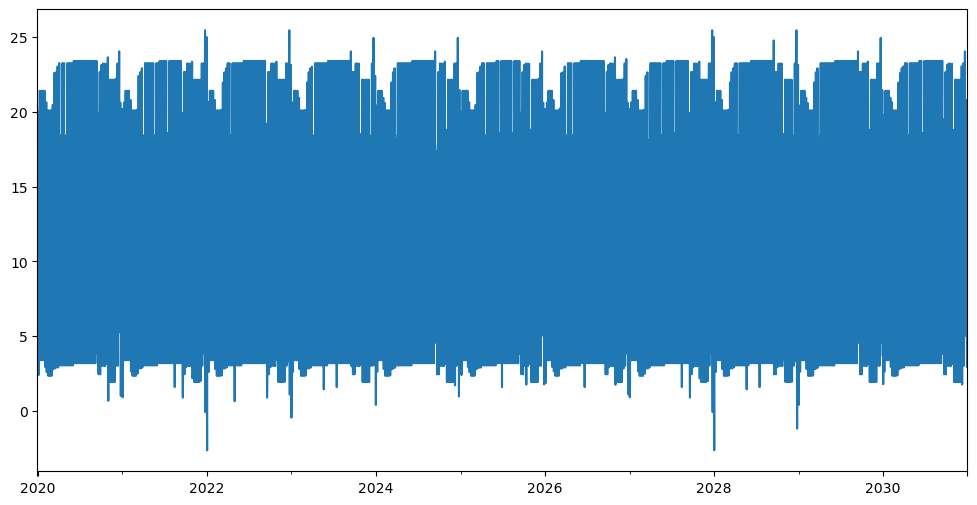

In [44]:
futuro_con_features["prediction"].plot()
plt.show()

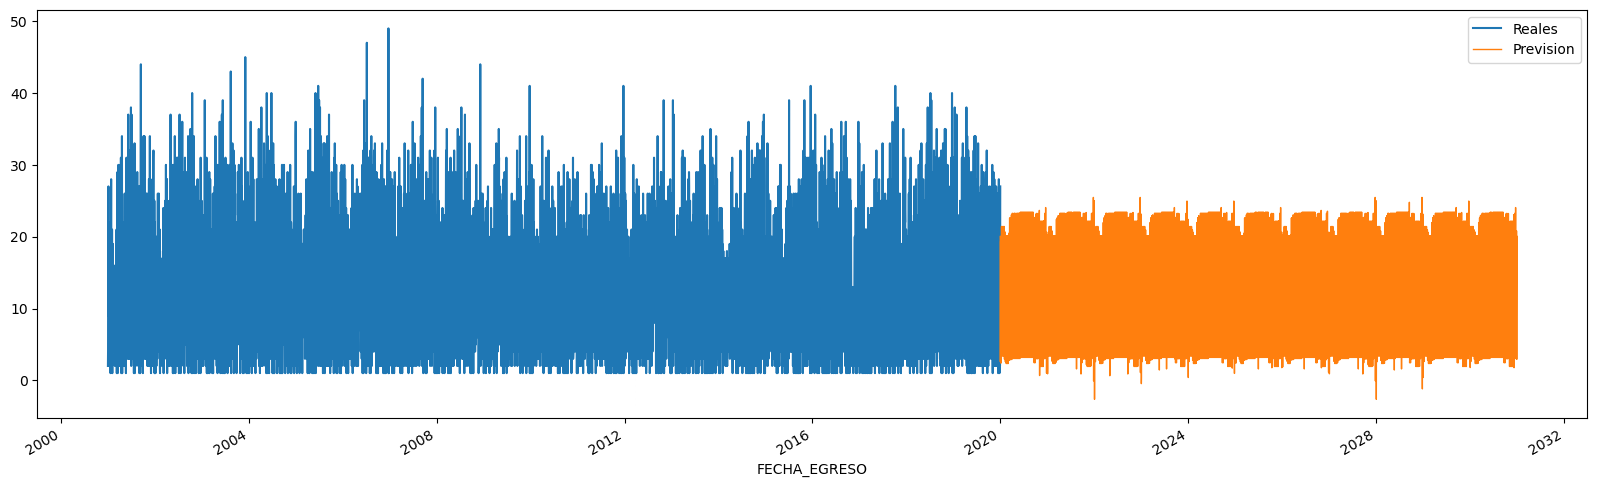

In [45]:
fig, axis = plt.subplots(1, 1, figsize=(20, 6))
resumen_egresos["n_egresos"].plot(ax=axis, label="Reales")
futuro_con_features["prediction"].plot(ax=axis, ms=1, lw=1, label="Prevision")
plt.legend()
plt.show()

## Obtención de modelos específicos para diagnósticos más relevantes del INT

Ahora que se ha realizado el modelo predictivo de los egresos totales del INT, se pasará a realizar
una predicción más minuciosa de los 45 diagnósticos más relevantes para el INT.


In [46]:
DIAGS_RELEVANTES = [
    "C33X",
    "C340",
    "C341",
    "C342",
    "C343",
    "C381",
    "C384",
    "C450",
    "C780",
    "C782",
    "D143",
    "D381",
    "E848",
    "I080",
    "I081",
    "I340",
    "I351",
    "I352",
    "I420",
    "I456",
    "I472",
    "I495",
    "I710",
    "I712",
    "J47X",
    "J679",
    "J841",
    "J848",
    "J849",
    "J860",
    "J869",
    "J955",
    "M348",
    "T820",
    "T821",
    "Z450",
]

In [47]:
egresos_mas_relevantes = egresos_torax[egresos_torax["DIAG1"].isin(DIAGS_RELEVANTES)].sort_values(
    "FECHA_EGRESO"
)

egresos_mas_relevantes["DIAG1"] = egresos_mas_relevantes["DIAG1"].astype("category").cat.codes
egresos_mas_relevantes = egresos_mas_relevantes[["FECHA_EGRESO", "n_egresos", "DIAG1"]]
egresos_mas_relevantes = egresos_mas_relevantes.set_index("FECHA_EGRESO")

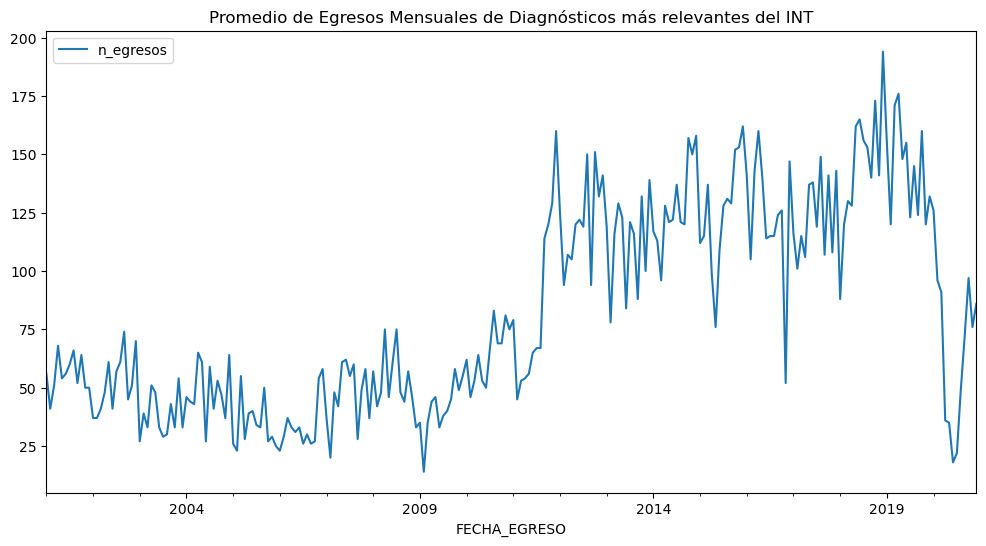

In [48]:
egresos_mas_relevantes.resample("M").sum().plot(
    y="n_egresos", title="Promedio de Egresos Mensuales de Diagnósticos más relevantes del INT"
)
plt.show()

Según el gráfico de los diagnósticos más relevantes, claramente se ve una tendencia al aumento
en la cantidad de egresos de estos diagnósticos.

<Axes: xlabel='FECHA_EGRESO'>

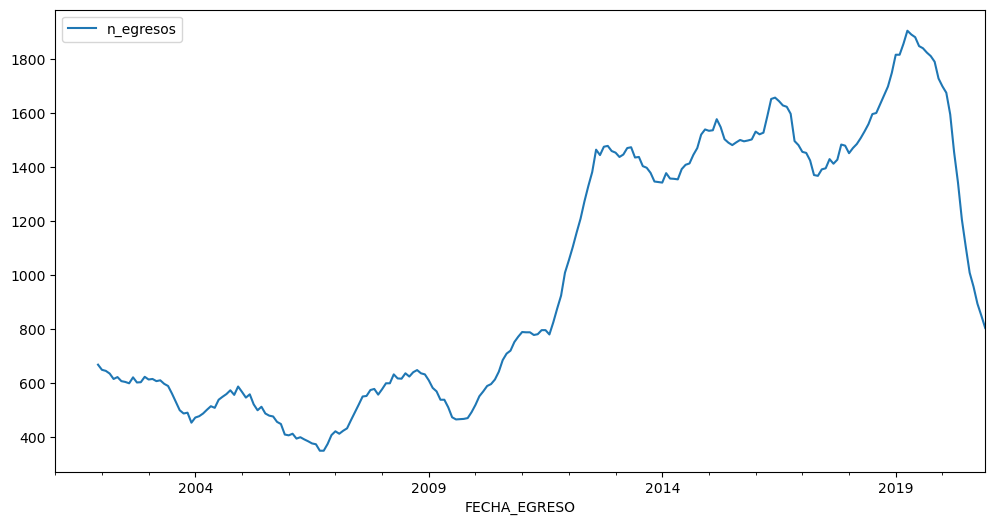

In [49]:
egresos_mas_relevantes.resample("M").sum().rolling(window=12).sum().plot(y="n_egresos")

Al ver como se mueve el promedio anual a lo lo largo de los años, nuevamente se observa una
tendencia al aumento en los egresos hospitalarios de estos diagnósticos. El salto observado entre
2011 a 2012 se explica por el cambio en codificación de la unidad de estadística a la unidad de
GRD (se asignaron diagnósticos más específicos). Luego de 2012, se observa una tendencia importante
al aumento de los diagnósticos relevantes.

## Entrenamiento de modelos para los diagnósticos más relevantes del INT

Una vez se ha visto el procedimiento para realizar modelos predictivos, se realizará el procedimiento con los diagnósticos más relevantes para el INT.

In [50]:
train = egresos_mas_relevantes[egresos_mas_relevantes.index <= "2018-12-31"]
valid = egresos_mas_relevantes[egresos_mas_relevantes.index > "2018-12-31"]

train = build_features.create_features_datetime_index(train)
valid = build_features.create_features_datetime_index(valid)

X_train = train.drop(columns="n_egresos")
y_train = train["n_egresos"]

X_valid = valid.drop(columns="n_egresos")
y_valid = valid["n_egresos"]

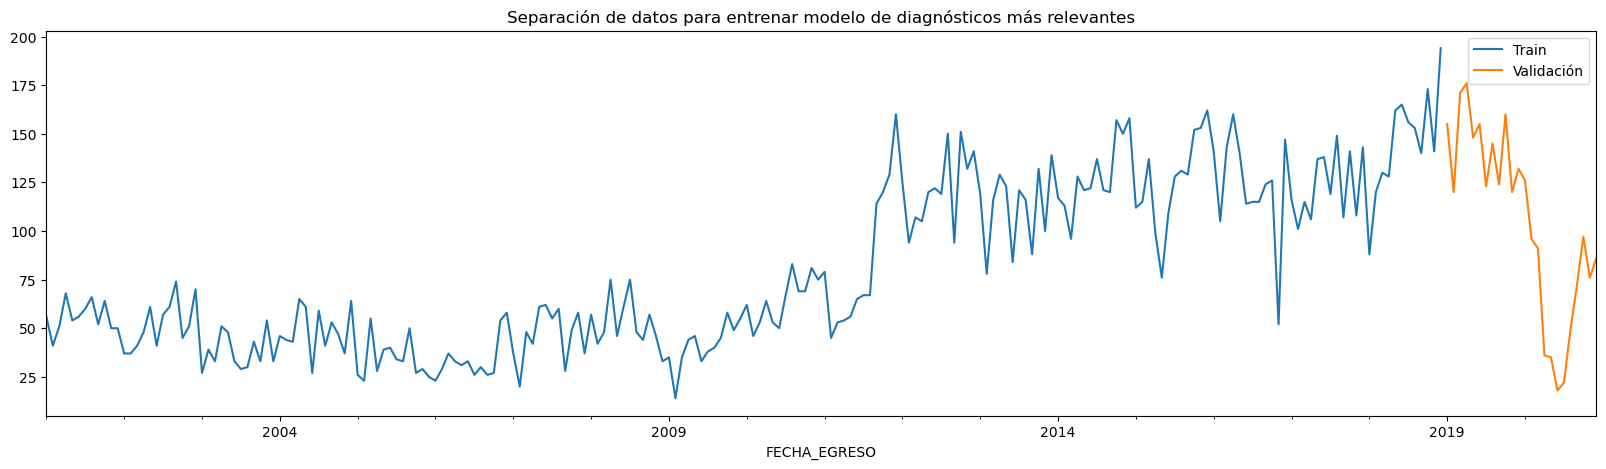

In [51]:
fig, axis = plt.subplots(1, 1, figsize=(20,5))
train.resample("M").sum().plot(y="n_egresos", label="Train", ax=axis)
valid.resample("M").sum().plot(y="n_egresos", label="Validación", ax=axis)
plt.legend()
plt.title("Separación de datos para entrenar modelo de diagnósticos más relevantes")
plt.show()

Para entrenar los modelos, se separarán los datos en un conjunto de entrenamiento y uno de
validación. Los datos de entrenamiento irán desde 2001 a 2018, mientras que los datos de validación
irán de 2019 a 2020.

Los datos de entrenamiento serán utilizados para realizar una validación cruzada de 5 separaciones. Dentro de la validación cruzada, cada conjunto de testeo utilizará aproximadamente 1 año de datos.

In [52]:
tss = TimeSeriesSplit(n_splits=5, test_size=900, gap=60)

grilla_parametros = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

estimador = XGBRegressor(
    objective="reg:squarederror",
)

busqueda_en_grilla = GridSearchCV(
    estimator=estimador,
    param_grid=grilla_parametros,
    cv=tss.split(train),
)

In [53]:
busqueda_en_grilla.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x13ec7efb0>,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)})

In [54]:
print(f"Los mejores parametros encontrados durante la busqueda en grilla fueron: {busqueda_en_grilla.best_params_}")

Los mejores parametros encontrados durante la busqueda en grilla fueron: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [55]:
yhat = busqueda_en_grilla.predict(X_valid)
mse = mean_squared_error(y_valid, yhat)
rmse_valid = np.sqrt(mse)
print(f"El MSE con el conjunto de validacion fue: {mse:.2f}")
print(f"El RMSE con el conjunto de validacion fue: {rmse_valid:.2f} egresos")

El MSE con el conjunto de validacion fue: 0.17
El RMSE con el conjunto de validacion fue: 0.41 egresos


In [56]:
valid["prediccion"] = yhat
valid["dif"] = (valid["prediccion"] - valid["n_egresos"])
valid["dif_sqrd"] = valid["dif"] ** 2
valid["dif_sqrd_root"] = np.sqrt(valid["dif_sqrd"])

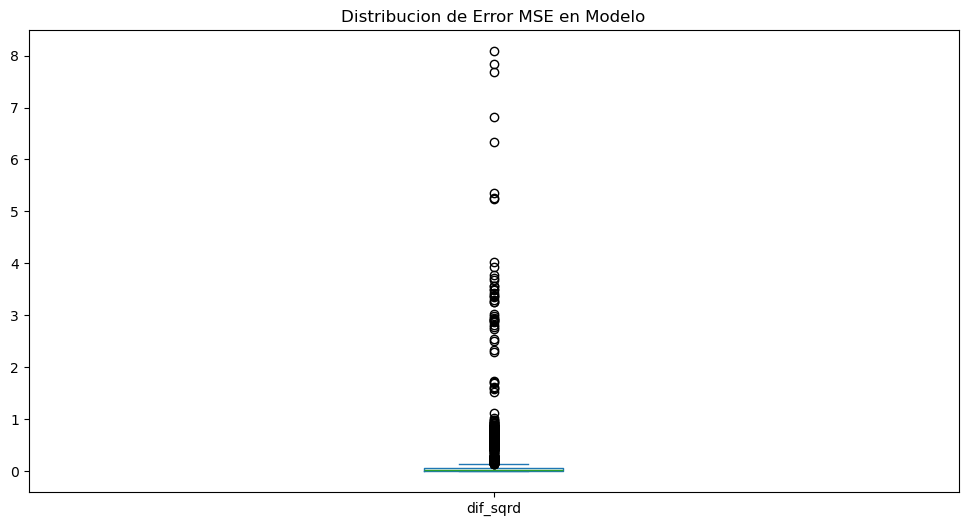

In [57]:
valid["dif_sqrd"].plot(kind="box", title="Distribucion de Error MSE en Modelo")
plt.show()

La distribución de errores MAE en el modelo indican que existe una parte importante de estos
que están entre 0.1 a 0.3 egresos de error. Sin embargo, también existe una parte importante de outliers. Esto puede indicar la necesidad de eliminar outliers en el conjunto de entrenamiento, o modelar tendencias puntuales al aumento.

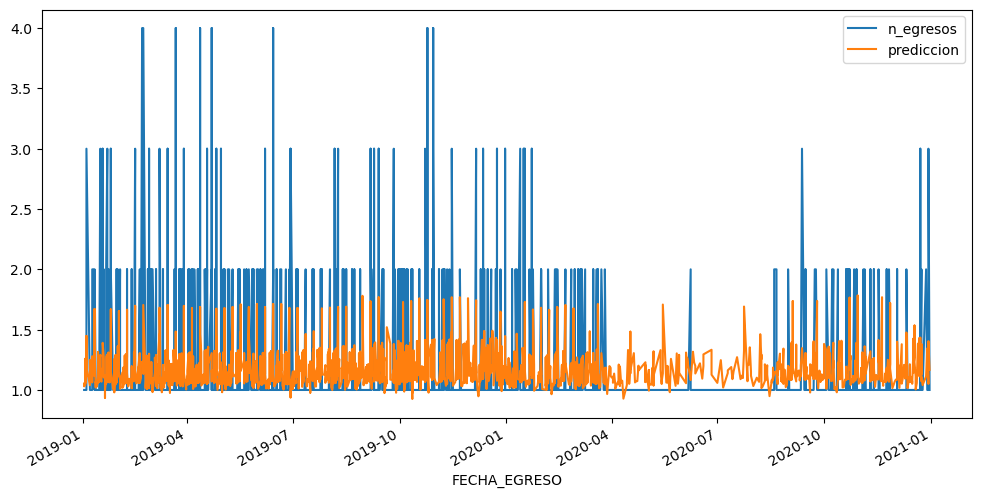

In [58]:
valid.plot(y=["n_egresos", "prediccion"])
plt.show()

Estos resultaos muestran que efectivamente falta modelar peaks de egresos en los datos.

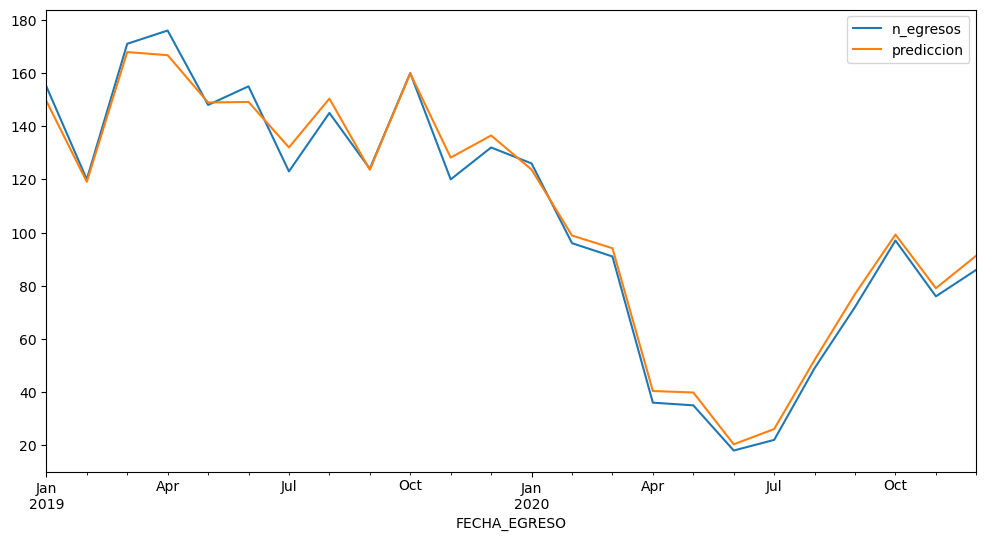

In [59]:
valid.resample("M").sum()[["n_egresos", "prediccion"]].plot()
plt.show()

Sin embargo, los resultados agrupados por mes muestran una predicción bastante satisfactoria.

## Predicción del Futuro

Ahora que ya se tiene un modelo entrenado para predecir los diagnósticos más relevantes, es
posible predecir la demanada de egresos para estos diagnósticos.

In [60]:
periodo_a_predecir = pd.date_range(start="2021-01-01", end="2035-01-01")

In [61]:
dfs = []
for i in train.DIAG1.unique():
    unico_df = pd.DataFrame(index=periodo_a_predecir)
    unico_df["DIAG1"] = i
    dfs.append(unico_df)

In [62]:
df_a_predecir = pd.concat(dfs)
df_a_predecir = build_features.create_features_datetime_index(df_a_predecir)
df_a_predecir["prediccion"] = busqueda_en_grilla.predict(df_a_predecir)

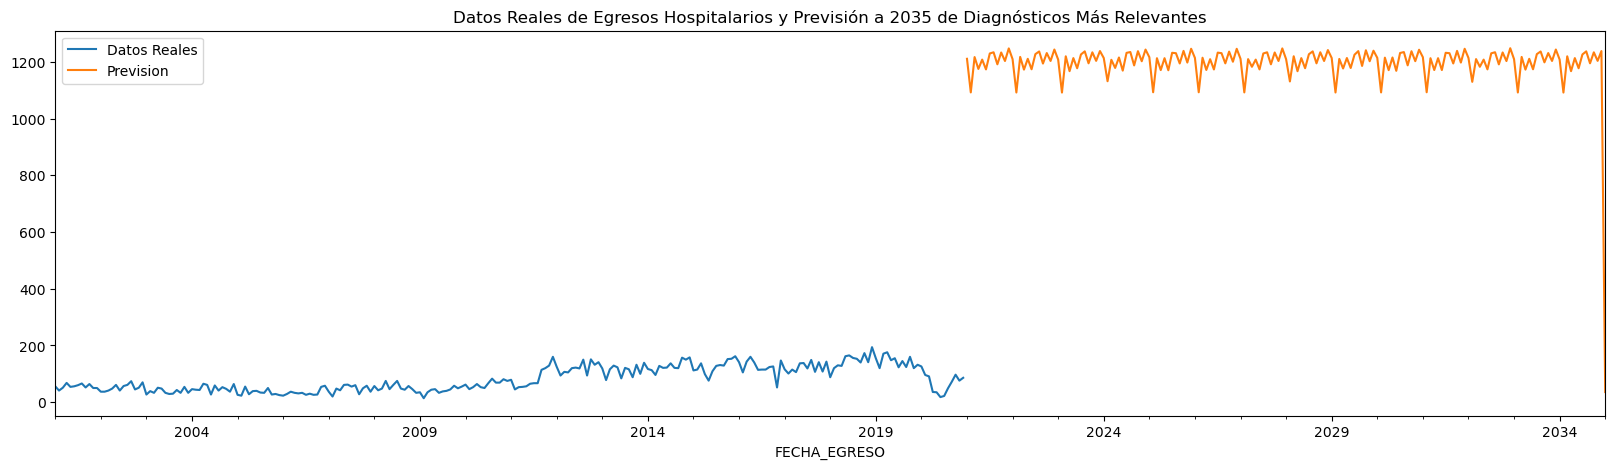

In [63]:
fig, axis = plt.subplots(1, 1, figsize=(20, 5))
egresos_mas_relevantes.resample("M").sum().plot(y="n_egresos", label="Datos Reales", ax=axis)
df_a_predecir.resample("M").sum().plot(y="prediccion", label="Prevision", ax=axis)
plt.legend()
plt.title("Datos Reales de Egresos Hospitalarios y Previsión a 2035 de Diagnósticos Más Relevantes")
plt.show()

Los resultados indican un aumento prominente de los egresos hospitalarios para los diagnósticos
más relevantes. A simple vista, estos resultados parecieran ser erróneos. Razones del por qué
estos resultados pueden ser erróneos son:

- El conjunto de previsión tiene una frecuencia mayor de predicción (todos los días del año
hasta 2035). Debido a esto, se predice una cantidad de egresos para todos los dias, sabiendo que quizás en el conjunto de entrenamiento existen fechas donde hay ausencia de egresos.

- La previsión de todos los próximos años tienen los mismos patrones. Esto estaría indicando que quizás la periodicidad de los datos está incorrectamente modelada.

- Los egresos predichos para cada años es aproximadamente la misma. Esto estaría indicando que el modelo carece de un componente de aumento a largo plazo o tendencia. Lo anterior se puede deber al modelo utilizado, ya que es conocido que los modelos basados en árboles fallan al modelar aumentos
graduales.

In [64]:
df_a_predecir

,DIAG1,dayofweek,quarter,day,month,year,dayofyear,weekend,holidays,prediccion
2021-01-01,21,4,1,1,1,2021,1,0,1,1.041498
2021-01-02,21,5,1,2,1,2021,2,1,0,1.009305
2021-01-03,21,6,1,3,1,2021,3,1,0,0.998909
2021-01-04,21,0,1,4,1,2021,4,0,0,1.032140
2021-01-05,21,1,1,5,1,2021,5,0,0,1.032140
...,...,...,...,...,...,...,...,...,...,...
2034-12-28,32,3,4,28,12,2034,362,0,0,1.093266
2034-12-29,32,4,4,29,12,2034,363,0,0,1.135162
2034-12-30,32,5,4,30,12,2034,364,1,0,1.019490
2034-12-31,32,6,4,31,12,2034,365,1,0,1.060980


## Predicción del Futuro con Prophet

- Como vimos anteriormente, el modelo basado en árboles es poco adecuado para predecir el futuro.
Debido a esto, es mejor utilizar un modelo aditivo que tome en cuenta las tendencias,
temporadas y ciclos. Uno de estos modelos es Prophet, hecho por Facebook.

- A modo de recordatorio, observaremos nuevamente los egresos de los diagnósticos más relevantes.

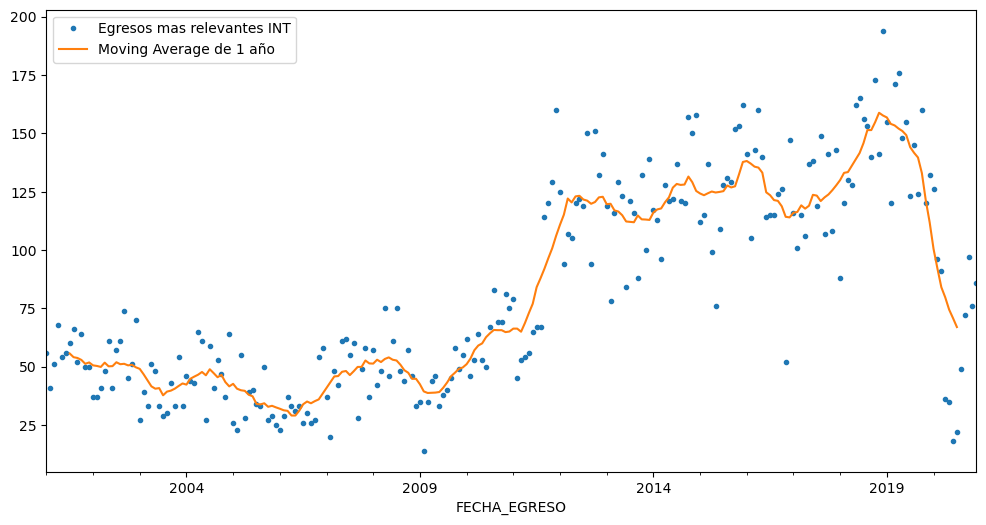

In [65]:
fig, axis = plt.subplots()
egresos_mensuales_relevantes = egresos_mas_relevantes.resample("M").sum().drop(columns="DIAG1")

egresos_mensuales_relevantes.plot(
    y="n_egresos", label="Egresos mas relevantes INT", ax=axis, style="."
)
egresos_mensuales_relevantes.rolling(12, center=True).mean().plot(
    y="n_egresos", label="Moving Average de 1 año", ax=axis
)
plt.show()

- De estos resultados se observa una tendencia al aumento. En primer lugar, se ve un aumento
considerable entre 2011 a 2012. Este aumento es atribuible al cambio de codificación de la unidad de estadística a GRD. Sin embargo, luego de 2012, se ve un aumento paulatino en la cantidad de egresos hasta 2019.

In [66]:
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [67]:
egresos_mas_relevantes_totales = egresos_mas_relevantes.resample("D").sum().drop(columns="DIAG1")

FECHA_CORTE = "2018-12-31"
train_prophet = egresos_mas_relevantes_totales[egresos_mas_relevantes_totales.index <= FECHA_CORTE]
test_prophet = egresos_mas_relevantes_totales[egresos_mas_relevantes_totales.index > FECHA_CORTE]

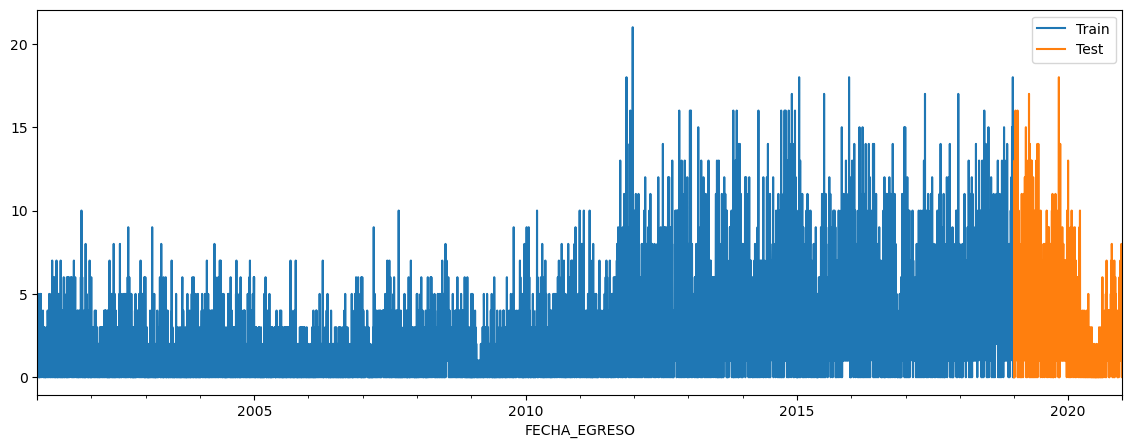

In [68]:
fig, axis = plt.subplots(figsize=(14, 5))

train_prophet.plot(y="n_egresos", label="Train", ax=axis)
test_prophet.plot(y="n_egresos", label="Test", ax=axis)
plt.legend()
plt.show()

## Modelo Prophet Simple

Primero, hay que renombrar las columnas

In [69]:
train_prophet = train_prophet.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})
test_prophet = test_prophet.reset_index().rename(columns={"FECHA_EGRESO": "ds", "n_egresos": "y"})

In [70]:
modelo = Prophet()
modelo.add_country_holidays("Chile")
modelo.fit(train_prophet)

11:52:05 - cmdstanpy - INFO - Chain [1] start processing
11:52:06 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
test_forecast = modelo.predict(test_prophet)

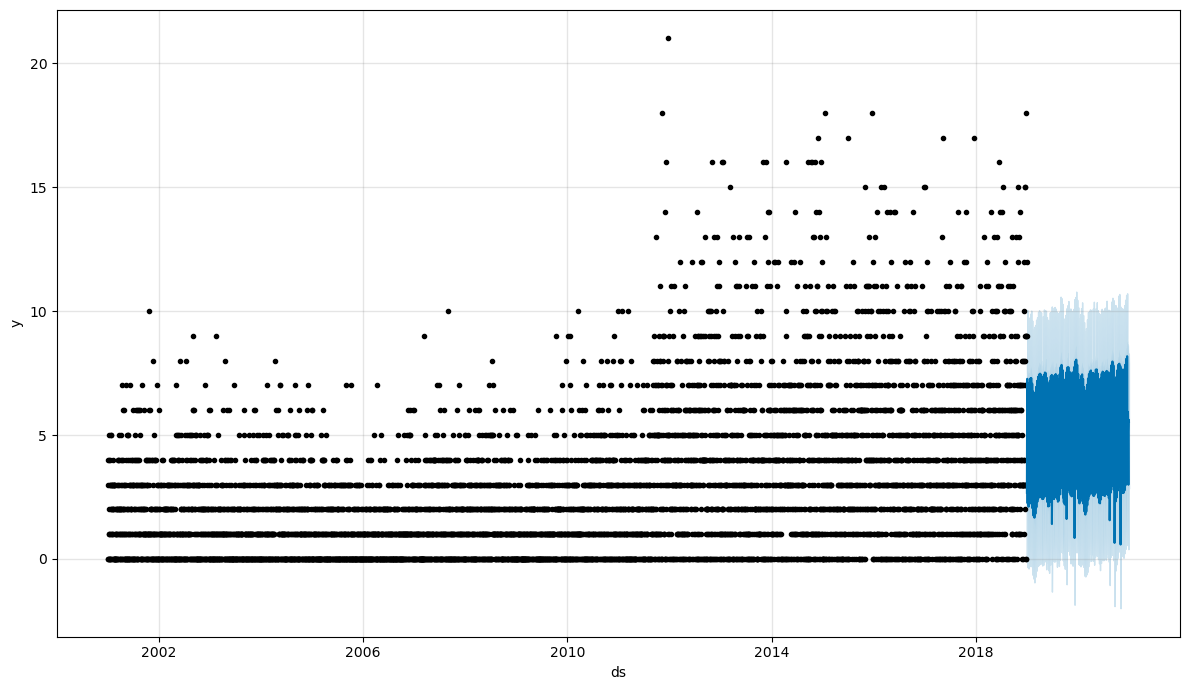

In [72]:
fig, axis = plt.subplots(1, 1, figsize=(12, 7))
fig = modelo.plot(test_forecast, ax=axis)
plt.show()

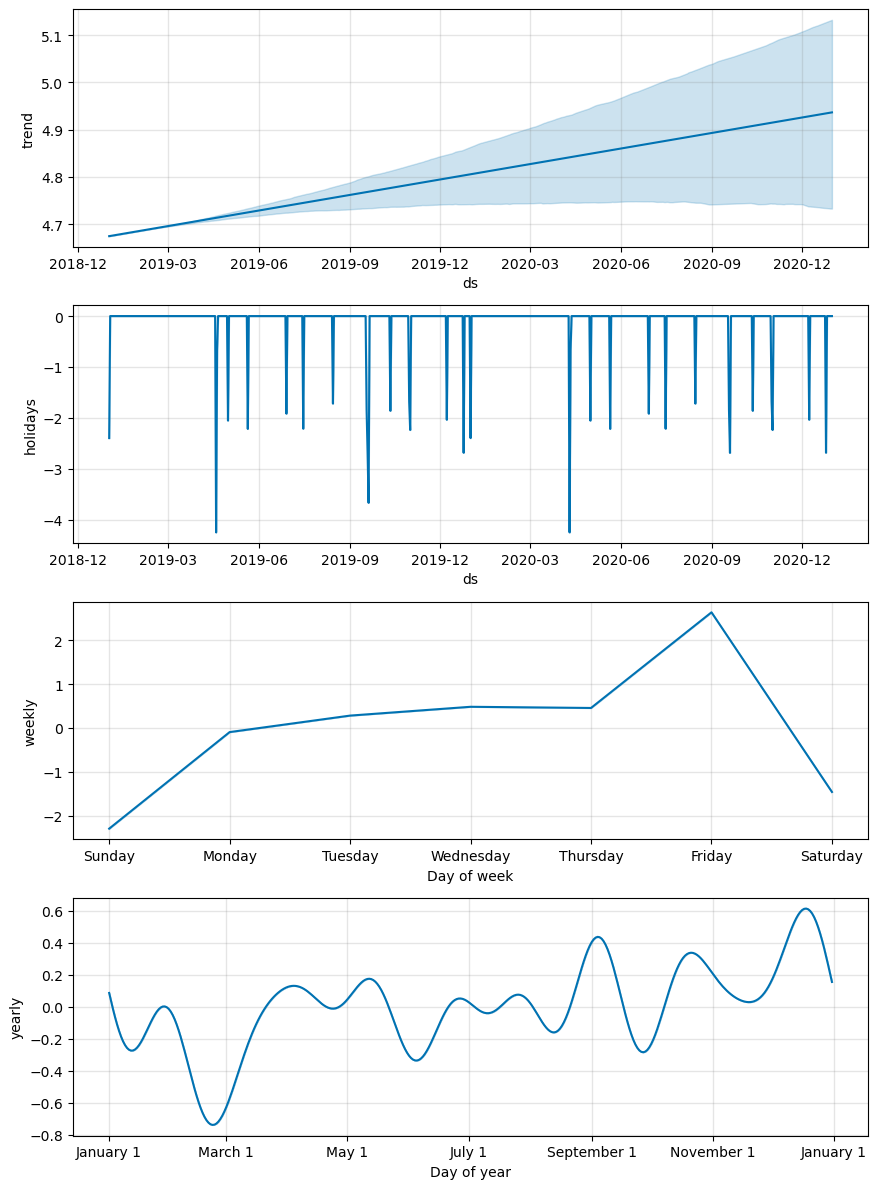

In [73]:
fig = modelo.plot_components(test_forecast)
plt.show()

Por lo tanto, se pueden visualizar todas las tendencias observadas segun el tiempo.

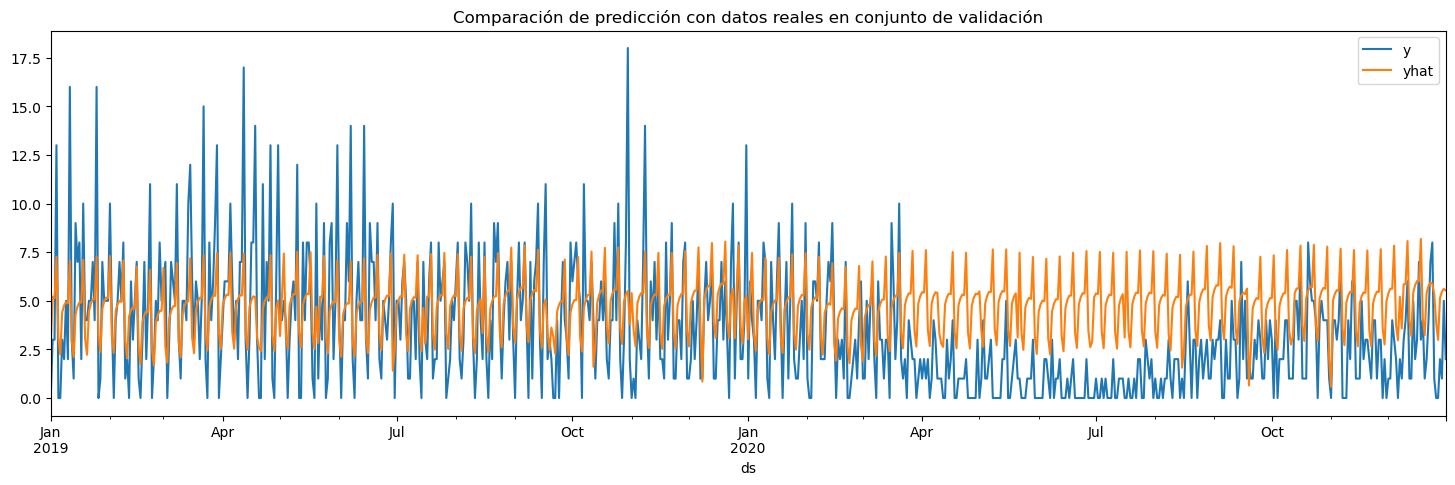

In [74]:
fig, axis = plt.subplots(1, 1, figsize=(18, 5))
test_prophet.plot(x="ds", y="y", ax=axis)
test_forecast.plot(x="ds", y="yhat", ax=axis)
plt.title("Comparación de predicción con datos reales en conjunto de validación")
plt.show()

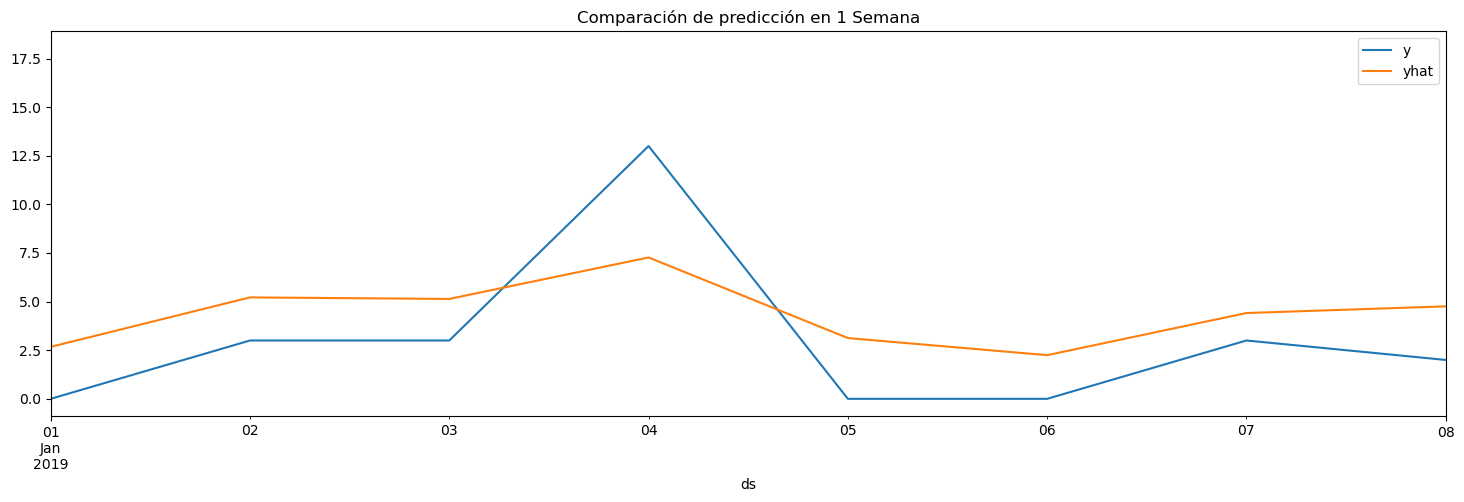

In [75]:
fig, axis = plt.subplots(1, 1, figsize=(18, 5))
test_prophet.plot(x="ds", y="y", ax=axis)
test_forecast.plot(x="ds", y="yhat", ax=axis)
axis.set_xbound(lower="01-01-2019", upper="01-08-2019")
plt.title("Comparación de predicción en 1 Semana")
plt.show()

En general, se puede ver que el desempeño del modelo fue deficiente. Esto se puede ver mejor al calcular una metrica de error.

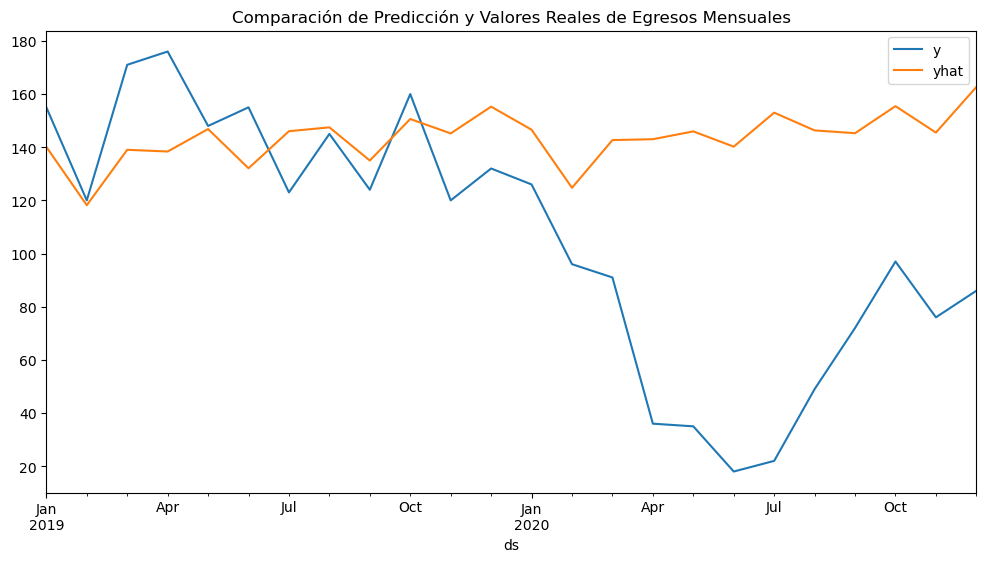

In [76]:
fig, axis = plt.subplots()
test_prophet.set_index("ds").resample("M").sum().plot(y="y", ax=axis)
test_forecast.set_index("ds").resample("M").sum().plot(y="yhat", ax=axis)
plt.title("Comparación de Predicción y Valores Reales de Egresos Mensuales")
plt.show()

## Evaluar Modelo Prophet con Metricas de Error

In [77]:
rmse_prophet = np.sqrt(mean_squared_error(y_true=test_prophet["y"], y_pred=test_forecast["yhat"]))
print(f"El error del modelo fue de: {rmse_prophet:.2f} Egresos")

El error del modelo fue de: 2.99 Egresos


Debemos tener en cuenta que el modelo está en egresos por día, por lo que un error de 3 egresos
por día es muy alto.

In [78]:
futuro = modelo.make_future_dataframe(periods=(365*17) + 4, include_history=False)
forecast_futuro = modelo.predict(futuro)

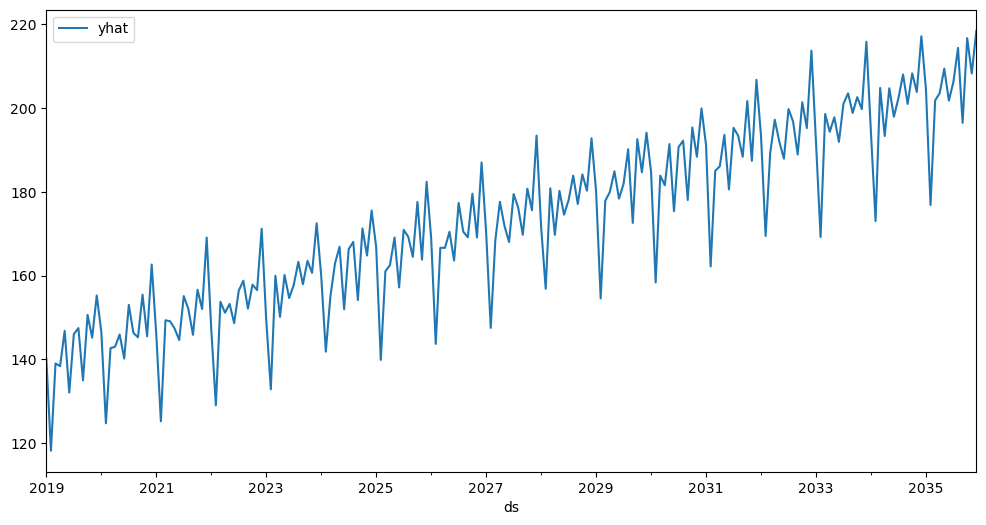

In [79]:
forecast_futuro.set_index("ds").resample("M").sum().plot(y="yhat")
plt.show()

In [80]:
egresos_mas_relevantes_totales.shift(1)

,n_egresos
FECHA_EGRESO,
2001-01-03,NaN
2001-01-04,3.0
2001-01-05,0.0
2001-01-06,4.0
2001-01-07,0.0
...,...
2020-12-27,0.0
2020-12-28,0.0
2020-12-29,2.0


In [81]:
from sklearn.linear_model import LinearRegression

In [82]:
relevantes_lineal = egresos_mas_relevantes_totales.copy()

In [83]:
relevantes_lineal["lag"] = relevantes_lineal.shift(1)
relevantes_lineal["index"] = [i for i in range(len(relevantes_lineal.index))]

In [84]:
X = relevantes_lineal[["index"]]
y = relevantes_lineal["n_egresos"]

y, X = y.align(X, join="inner")

model = LinearRegression()

In [85]:
model.fit(X, y)

LinearRegression()

In [86]:
y_pred = pd.Series(model.predict(X), index=X.index)

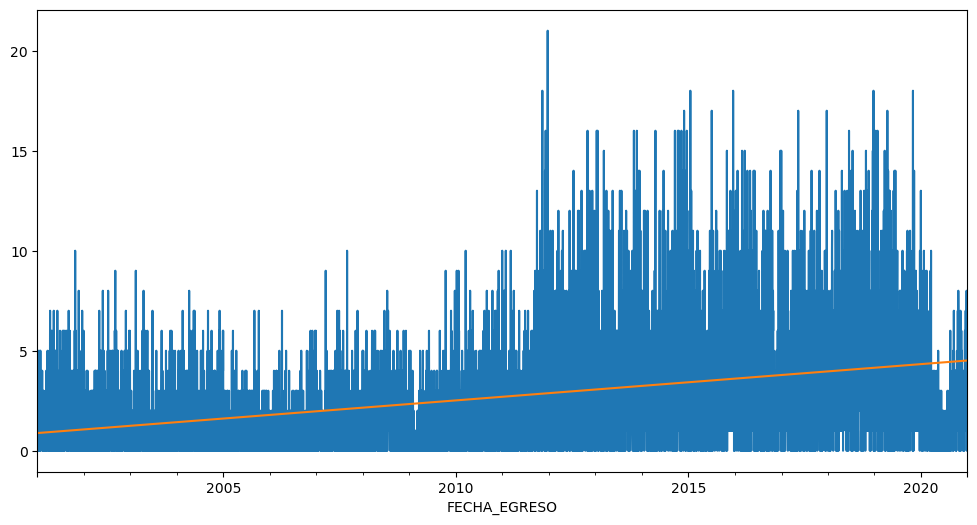

In [87]:
ax = y.plot()
ax = y_pred.plot()

## Predicción con Modelo híbrido

Una forma de predicción es con un modelo lineal para capturar la tendencia, y otro para capturar
los demas componentes con un modelo de Gradient Boosting.

In [88]:
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import DeterministicProcess

In [89]:
train = egresos_mas_relevantes_totales[egresos_mas_relevantes_totales.index <= FECHA_CORTE]
valid = egresos_mas_relevantes_totales[
    (egresos_mas_relevantes_totales.index >= FECHA_CORTE)
    & (egresos_mas_relevantes_totales.index < "2020-01-01")
]

TypeError: ModeloHibrido.__init__() missing 2 required positional arguments: 'param_grid_1' and 'param_grid_2'

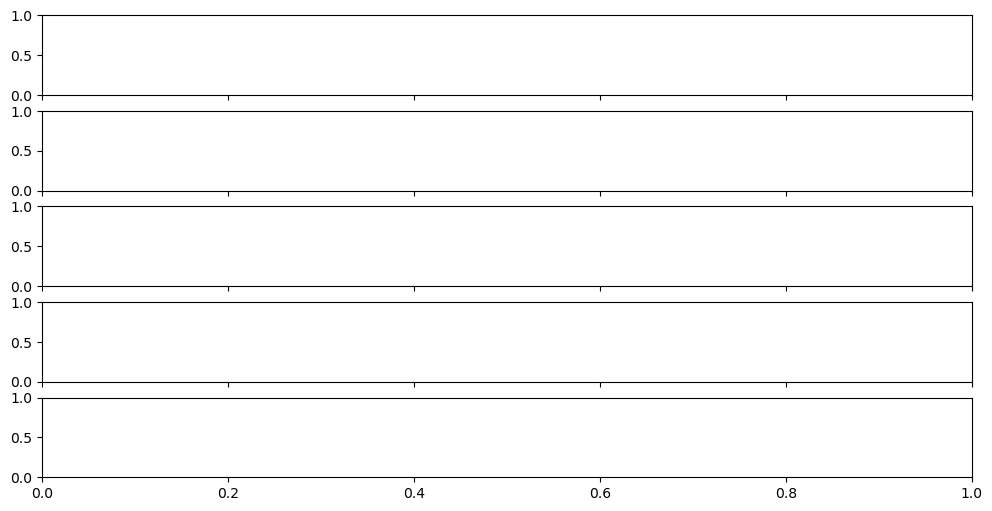

In [90]:
tss = TimeSeriesSplit(n_splits=5, test_size=365)
fig, axis = plt.subplots(5, 1, sharex=True)

modelo_hibrido = train_model.ModeloHibrido(
    LinearRegression(), XGBRegressor(learning_rate=0.1, max_depth=3, n_estimators=100)
)
TARGET = "n_egresos"

resultados_folds = []

for i, (idx_train, idx_test) in enumerate(tss.split(train)):
    train_cv = train.iloc[idx_train]
    test_cv = train.iloc[idx_test]
    train_cv.plot(y=TARGET, ax=axis[i], label="Train")
    test_cv.plot(y=TARGET, ax=axis[i], label="Test")

    X_train_cv_1 = DeterministicProcess(index=train_cv.index, order=1, drop=True).in_sample()
    X_train_cv_2 = build_features.create_features_datetime_index(train_cv).drop(columns=TARGET)
    y_train = train_cv[TARGET]

    X_test_cv_1 = DeterministicProcess(index=test_cv.index, order=1, drop=True).in_sample()
    X_test_cv_2 = build_features.create_features_datetime_index(test_cv).drop(columns=TARGET)
    y_test = test_cv[TARGET]

    X_valid_1 = DeterministicProcess(index=valid.index, order=1, drop=True).in_sample()
    X_valid_2 = build_features.create_features_datetime_index(valid).drop(columns=TARGET)
    y_valid = valid[TARGET]

    modelo_hibrido.fit(X_train_cv_1, X_train_cv_2, y_train)
    yhat_cv = modelo_hibrido.predict(X_test_cv_1, X_test_cv_2)
    rmse_cv = np.sqrt(mean_squared_error(y_test, yhat_cv))

    yhat_valid = modelo_hibrido.predict(X_valid_1, X_valid_2)
    rmse_valid = np.sqrt(mean_squared_error(y_valid, yhat_valid))
    print(f"El resultado del fold {i} fue: {rmse_cv:.2f} egresos - Valid: {rmse_valid:.2f}")
    resultados_folds.append(rmse_cv)

## Predicción con todo el conjunto de entrenamiento

In [ ]:
X_1 =  DeterministicProcess(index=train.index, order=1, drop=True).in_sample()
X_2 = build_features.create_features_datetime_index(train).drop(columns=TARGET)

yhat = modelo_hibrido.predict(X_1, X_2)

In [ ]:
prediccion_total_hibrido = train.copy()
prediccion_total_hibrido["prediccion"] = yhat

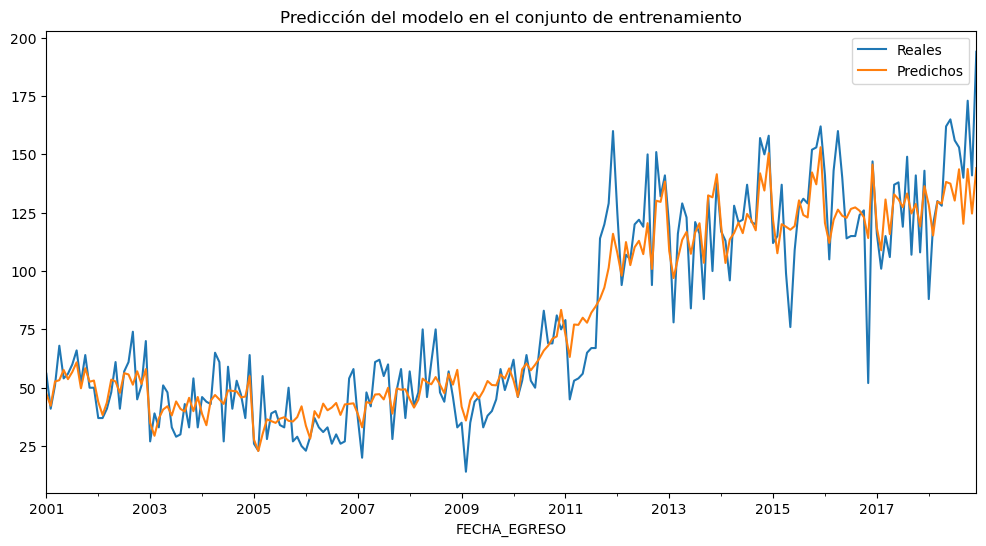

In [ ]:
fig, axis = plt.subplots()
prediccion_total_hibrido.resample("M").sum().plot(y="n_egresos", label="Reales", ax=axis)
prediccion_total_hibrido.resample("M").sum().plot(y="prediccion", label="Predichos", ax=axis)
plt.title("Predicción del modelo en el conjunto de entrenamiento")
plt.show()

## Previsión del modelo hasta 2035.

In [ ]:
X_1_forecast = DeterministicProcess(
    index=egresos_mas_relevantes_totales.index, order=1, drop=True
).out_of_sample(steps=365 * 15)

X_2_forecast = build_features.create_features_datetime_index(X_1_forecast).drop(columns="trend")
yhat_forecast = modelo_hibrido.predict(X_1_forecast, X_2_forecast)

In [ ]:
prevision_hibrida = X_1_forecast.copy()
prevision_hibrida["prediccion"] = yhat_forecast

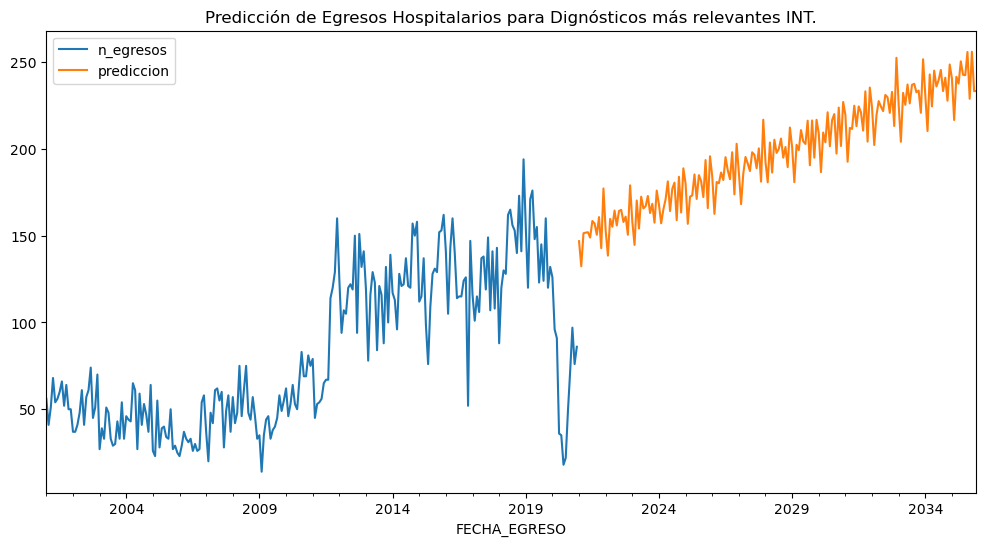

In [ ]:
fig, axis = plt.subplots()
egresos_mas_relevantes_totales.resample("M").sum().plot(y="n_egresos", ax=axis)
prevision_hibrida.resample("M").sum().plot(y="prediccion", ax=axis)
plt.title("Predicción de Egresos Hospitalarios para Dignósticos más relevantes INT.")
plt.show()

Una de las cosas que se quieren mejorar en el modelo es:

- Realizar una busqueda de hiperparametros con Validacion Cruzada para mejorar el desempeño del
modelo. Se quiere llegar a un desempeño similar al modelo de Gradient Boosting, pero manteniendo
la predicción de la tendencia a largo plazo.

- Agregar el componente ciclico a los datos de Gradient Boosting.

- Realizar la predicción desagregada. O sea, realizar una predicción para cada uno de los diagnósticos por separado.

El primer punto que se atenderá será incluir el componente ciclico de los datos con ```lag_features```.

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf

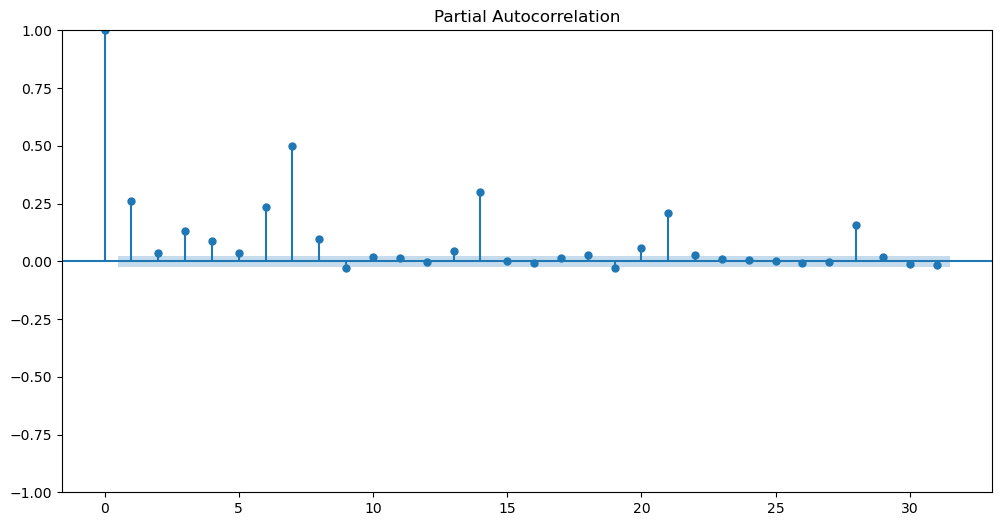

In [ ]:
fig = plot_pacf(egresos_mas_relevantes_totales["n_egresos"], lags=31)

El gráfico de autocorrelación muestra que los lags más importantes son cada 1 semana (shift 7,
14, 21, 28), además de los lags 1 y 6. Debido a lo anterior, se modelarán tales variables en el
modelo.

## Preprocesamiento completo

In [91]:
y_train = train[TARGET]

X_1_train = DeterministicProcess(index=train.index, order=1, drop=True).in_sample()
X_2_train = build_features.create_features_datetime_index(train)
X_2_train = build_features.create_lag_features(
    X_2_train, "n_egresos", [1, 6, 7, 14], 0
)
X_2_train = X_2_train.drop(columns=TARGET)

In [92]:
y_valid = valid[TARGET]

X_1_valid = DeterministicProcess(index=valid.index, order=1, drop=True).in_sample()
X_2_valid = build_features.create_features_datetime_index(valid)
X_2_valid = build_features.create_lag_features(X_2_valid, "n_egresos", [1, 6, 7, 14], 0)
X_2_valid = X_2_valid.drop(columns=TARGET)

## Entrenamiento de modelos con validación cruzada

In [99]:
# Define models

modelo_1 = LinearRegression()
modelo_2 = XGBRegressor()


# Create the hyperparameter grids for each model
param_grid_1 = {"fit_intercept": [True, False]}

param_grid_2 = {
    "max_depth": range(2, 10, 1),
    "n_estimators": range(60, 220, 40),
    "learning_rate": [0.1, 0.01, 0.05],
}

# Example usage
# Assuming modelo_1 and modelo_2 are instances of scikit-learn models

# Create the hybrid model
hybrid_model = train_model.ModeloHibrido(
    modelo_1, modelo_2, param_grid_1, param_grid_2, n_splits=5
)

# Fit the model
hybrid_model.fit(X_1_train, X_2_train, y_train)

# Access the best hyperparameters and CV results
best_params_1 = hybrid_model.best_params_1
best_params_2 = hybrid_model.best_params_2
cv_results_1 = hybrid_model.cv_results_1
cv_results_2 = hybrid_model.cv_results_2

# Make predictions
predictions = hybrid_model.predict(X_1_train, X_2_train)

Tuning modelo_1...
Best hyperparameters for modelo_1: {'fit_intercept': True}
CV Results for modelo_1:
  Mean Train Score: -3.875834404735442
  Mean Test Score: -8.385184491600587

Tuning modelo_2...
Best hyperparameters for modelo_2: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 180}
CV Results for modelo_2:
  Mean Train Score: -1.6289365916373633
  Mean Test Score: -5.063530086421376

Training process completed.
